### Imports

In [128]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import math
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from tqdm.notebook import tqdm
from importlib import reload
import valuation

### Load CIFAR datasets

In [188]:
# change path where data is stored
data_path = '../data'
data_dir = Path(data_path)

# use training set for buyer data and test set for seller
cifar_orig_buyer = CIFAR10(root='../data', train=True, download=True)
cifar_orig_seller = CIFAR10(root='../data', train=False, download=True)
buyer_data = cifar_orig_buyer.data
buyer_targets = cifar_orig_buyer.targets
seller_data = cifar_orig_seller.data
seller_targets = cifar_orig_seller.targets

# load corrupted version of cifar test set
cifar_noise_path = data_dir / 'CIFAR-10-C'
gauss_data = np.load(cifar_noise_path / 'gaussian_noise.npy')
gauss_targets = np.array(seller_targets)
impulse_data = np.load(cifar_noise_path / 'impulse_noise.npy')
impulse_targets = np.array(seller_targets)
jpeg_data = np.load(cifar_noise_path / 'jpeg_compression.npy')
jpeg_targets = np.array(seller_targets)
blur_data = np.load(cifar_noise_path / 'motion_blur.npy')
blur_targets = np.array(seller_targets)
contrast_data = np.load(cifar_noise_path / 'contrast.npy')
contrast_targets = np.array(seller_targets)


# load distribution shifted version of cifar dataset
cifar_shift_path = data_dir / 'CIFAR-10.1/datasets'
shift_data = np.load(cifar_shift_path / 'cifar10.1_v4_data.npy')
shift_targets = np.load(cifar_shift_path / 'cifar10.1_v4_labels.npy')

Files already downloaded and verified
Files already downloaded and verified


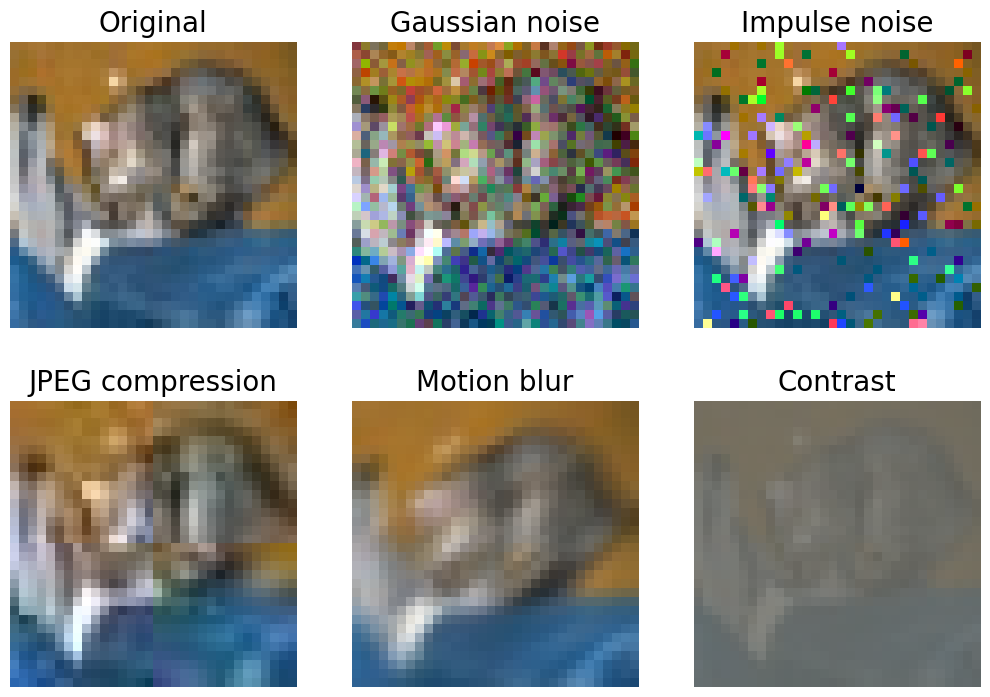

In [189]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
ax[0, 0].imshow(seller_data[0])
ax[0, 1].imshow(gauss_data[40000])
ax[0, 2].imshow(impulse_data[40000])
ax[1, 0].imshow(jpeg_data[40000])
ax[1, 1].imshow(blur_data[40000])
ax[1, 2].imshow(contrast_data[40000])
ax[0, 0].set_title('Original', fontsize=20, pad=8)
ax[0, 1].set_title('Gaussian noise', fontsize=20, pad=8)
ax[0, 2].set_title('Impulse noise', fontsize=20, pad=8)
ax[1, 0].set_title('JPEG compression', fontsize=20, pad=8)
ax[1, 1].set_title('Motion blur', fontsize=20, pad=8)
ax[1, 2].set_title('Contrast', fontsize=20, pad=8)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

fig.tight_layout(h_pad=4, w_pad=4)
plt.savefig('figures/cifar-images.png', bbox_inches='tight')

### Embed image data through pre-trained model

In [190]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
model.eval();

make_loader = lambda x, bs=32: DataLoader(TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs)
embed_data = lambda x, mod: torch.cat([mod(x[0].cuda()).detach().cpu() for x in tqdm(make_loader(x))])

# embed_buyer_data = embed_data(buyer_data, model)
# embed_seller_data = embed_data(seller_data, model)
# embed_shift_data = embed_data(shift_data, model)
# embed_gauss_data = embed_data(gauss_data, model)
# embed_impulse_data = embed_data(impulse_data, model)
# embed_jpeg_data = embed_data(jpeg_data, model)
# embed_blur_data = embed_data(blur_data, model)
embed_contrast_data = embed_data(contrast_data, model)

  0%|          | 0/1563 [00:00<?, ?it/s]

### Data valuations

In [191]:
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller)
    vol = valuation.get_volume(np.cov(pca.transform(seller).T))
    return rel, max(vol, 1e-5)


# Change number of buyer components to project to calculate diversity and relevance
n_components=5

buyer_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
buyer_pca.fit(embed_buyer_data)

buyer_rel, buyer_div = get_value(buyer_pca, embed_buyer_data)
seller_rel, seller_div = get_value(buyer_pca, embed_seller_data)
shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)


# CIFAR-C dataset has 5 noise levels for each corruption
gauss_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    gauss_rel, gauss_div = get_value(buyer_pca, embed_gauss_data[s])
    gauss_valuations['relevance'].append(gauss_rel)
    gauss_valuations['diversity'].append(gauss_div)
    
impulse_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    impulse_rel, impulse_div = get_value(buyer_pca, embed_impulse_data[s])
    impulse_valuations['relevance'].append(impulse_rel)
    impulse_valuations['diversity'].append(impulse_div)
    
jpeg_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    jpeg_rel, jpeg_div = get_value(buyer_pca, embed_jpeg_data[s])
    jpeg_valuations['relevance'].append(jpeg_rel)
    jpeg_valuations['diversity'].append(jpeg_div)
    
blur_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    blur_rel, blur_div = get_value(buyer_pca, embed_blur_data[s])
    blur_valuations['relevance'].append(blur_rel)
    blur_valuations['diversity'].append(blur_div)
    
contrast_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    contrast_rel, contrast_div = get_value(buyer_pca, embed_contrast_data[s])
    contrast_valuations['relevance'].append(contrast_rel)
    contrast_valuations['diversity'].append(contrast_div)

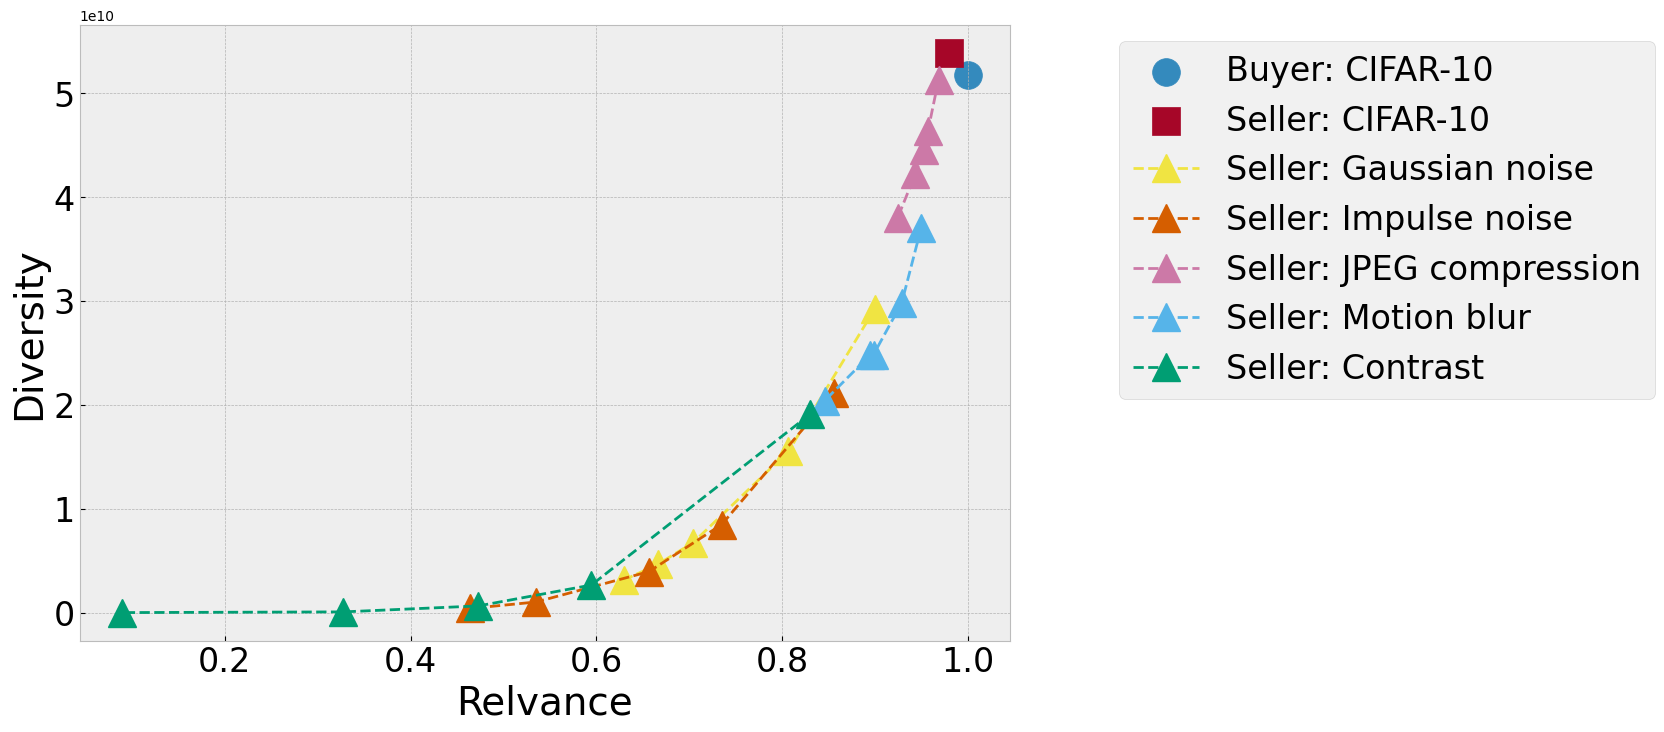

In [199]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=s, marker='o', label='Buyer: CIFAR-10')
plt.scatter(seller_rel, seller_div, s=s, marker='s', label='Seller: CIFAR-10')
# plt.scatter(shift_rel, shift_div, s=s, marker='D', label='Seller: CIFAR-10.1')
plt.plot(gauss_valuations['relevance'], gauss_valuations['diversity'], '^--', c='C8', markersize=20, label=f'Seller: Gaussian noise')
plt.plot(impulse_valuations['relevance'], impulse_valuations['diversity'], '^--', c='C4', markersize=20, label=f'Seller: Impulse noise')
plt.plot(jpeg_valuations['relevance'], jpeg_valuations['diversity'], '^--', c='C5', markersize=20, label=f'Seller: JPEG compression')
plt.plot(blur_valuations['relevance'], blur_valuations['diversity'], '^--', c='C6', markersize=20, label=f'Seller: Motion blur')
plt.plot(contrast_valuations['relevance'], contrast_valuations['diversity'], '^--', c='C7', markersize=20, label=f'Seller: Contrast')
    
plt.xlabel('Relvance', fontsize=28)
plt.ylabel('Diversity', fontsize=28)
# plt.xlim(0, 1.1)
# plt.title(fontsize=20, pad=12)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24, bbox_to_anchor=(1.1, 1))
plt.savefig('figures/cifar-noise.png', bbox_inches='tight')